In [1]:
import glob
import pathlib
import pickle
import requests
import tarfile
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import decomposition, ensemble, linear_model, metrics, tree
from sklearn import model_selection, pipeline, preprocessing

# Working with real data

## CIFAR-10 Dataset

# Look at the Big Picture

Our goal over these two hands-on workshops will be to build a machine learning modeling pipeline that is capable of classifying images. Today we will mostly focus on classical machine learning algorithms implemented in Scikit-Learn; tomorrow we will revist the same problem using deep learning algorithms implemented in PyTorch. By the time you have finished this two-day workshop you should understand how to build a machine learning application capable of classifying images and be ready to apply what you have learned to a new dataset.

This morning we will mostly focus on getting the data and exploring the data to gain new insights. Believe it or not these initial steps are what data scientists and machine learning engineers spend the majority of their time doing! This afternoon we will prepare our data for machine learning, see how to fit a variety of machine learning models to our dataset and shortlist a few candidate models for further analysis. We will then use hyper-parameter tuning to improve the performance of our shortlisted models to arrive at an overall "best" model. We will finish with a discussion of how to present the results of your model and talk about some of the aspects of deploying a trained model to make predictions.

## Framing the problem

### What is the business/research objective?

Typically building the model is not the overall objective but rather the model itself is one part of a larger process used to answer a business/research question. Knowing the overall objective is important because it will determine your choice of machine learning algorithms to train, your measure(s) of model performance, and how much time you will spend tweaking the hyper-parameters of your model.

In our example today, the overall business/research objective is to make money from serving targeted ads to users of a social media application based on the images that they post. Our image classication model might just be one of potentially many other models whose predictions are taken as inputs into another machine learning model that will be used to determine which ads to show to users. 

## Select a performance measure

## Download and extract the data

In [56]:
DATA_DIR = pathlib.Path("../data/")
RAW_DATA_DIR = DATA_DIR / "cifar-10"
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"


RAW_DATA_DIR.mkdir(exist_ok=True)
    
with open(RAW_DATA_DIR / "cifar-10-python.tar.gz", "wb") as f:
    response = requests.get(URL)
    f.write(response.content)

with tarfile.open(RAW_DATA_DIR / "cifar-10-python.tar.gz", "r:gz") as f:
    f.extractall(RAW_DATA_DIR)
    

## Load the data

In [3]:
data = []
labels = []
filepaths = glob.glob("../data/cifar-10/cifar-10-batches-py/*_batch*")
for filepath in sorted(filepaths):
    with open(filepath, "rb") as f:
        batch = pickle.load(f, encoding="latin1")
        data.append(batch["data"])
        labels.extend(batch["labels"])
        
# each image has 3 channels with height and width of 32 pixels
features = pd.DataFrame(np.vstack(data), columns= [f"p{i}" for i in range(3 * 32 * 32)], dtype="uint8")
target = pd.Series(labels, dtype="uint8", name="labels")

In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 3072 entries, p0 to p3071
dtypes: uint8(3072)
memory usage: 175.8 MB


In [5]:
features.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p3062,p3063,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071
0,59,43,50,68,98,119,139,145,149,149,...,59,58,65,59,46,57,104,140,84,72
1,154,126,105,102,125,155,172,180,142,111,...,22,42,67,101,122,133,136,139,142,144
2,255,253,253,253,253,253,253,253,253,253,...,78,83,80,69,66,72,79,83,83,84
3,28,37,38,42,44,40,40,24,32,43,...,53,39,59,42,44,48,38,28,37,46
4,170,168,177,183,181,177,181,184,189,189,...,92,88,85,82,83,79,78,82,78,80


In [6]:
features.describe()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p3062,p3063,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,130.681517,130.115950,131.066200,131.665183,132.308817,132.966350,133.495883,134.026067,134.61445,135.062000,...,113.821667,113.827283,113.895817,113.908417,113.927250,114.008467,114.024900,113.999500,114.051200,114.539400
std,73.399021,72.434476,72.247946,71.970096,71.649751,71.482859,71.297035,71.249209,71.05503,71.031128,...,64.117121,64.259621,64.354673,64.315537,64.441507,64.451986,64.671902,64.820143,65.162783,66.008946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71.000000,71.000000,73.000000,73.000000,75.000000,76.000000,76.000000,77.000000,78.00000,78.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,63.000000
50%,128.000000,127.000000,128.000000,129.000000,130.000000,131.000000,132.000000,133.000000,133.00000,134.000000,...,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
75%,189.000000,188.000000,189.000000,189.000000,189.000000,190.000000,190.000000,191.000000,191.00000,192.000000,...,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,159.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [7]:
target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 60000 entries, 0 to 59999
Series name: labels
Non-Null Count  Dtype
--------------  -----
60000 non-null  uint8
dtypes: uint8(1)
memory usage: 58.7 KB


In [8]:
target.head()

0    6
1    9
2    9
3    4
4    1
Name: labels, dtype: uint8

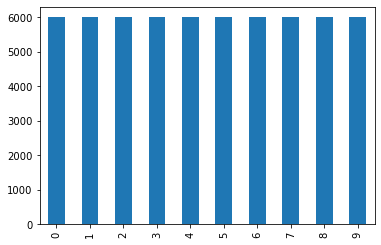

In [9]:
_ = (target.value_counts()
           .sort_index()
           .plot(kind="bar"))

Write out the features and the target to disk.

In [20]:
_ = (features.join(target)
             .to_csv(RAW_DATA_DIR / "cifar-10.csv", index=False))

# Creating a test dataset

In [ ]:
model_selection.train_test_split?

In [11]:
SEED = 42
TEST_SIZE = 1e-1

# split the dataset into training and testing data
_random_state = (np.random
                   .RandomState(SEED))
train_features, test_features, train_target, test_target = model_selection.train_test_split(
    features,
    target,
    test_size=TEST_SIZE,
    random_state=_random_state
)

In [12]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 50404 to 56422
Columns: 3072 entries, p0 to p3071
dtypes: uint8(3072)
memory usage: 158.6 MB


In [13]:
train_features.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p3062,p3063,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071
50404,215,201,190,187,183,182,184,184,186,189,...,69,69,69,69,80,88,95,95,95,96
26810,190,168,148,150,157,158,175,210,217,218,...,116,116,111,105,111,117,121,119,116,125
19681,131,126,134,162,173,177,181,183,184,187,...,125,129,134,137,141,147,152,157,111,48
7616,162,155,158,161,154,144,151,142,136,136,...,118,112,115,115,107,116,107,99,94,94
20363,31,37,47,75,54,44,45,77,143,122,...,109,109,99,100,100,106,109,111,103,103


In [14]:
train_target.head()

50404    8
26810    7
19681    3
7616     2
20363    4
Name: labels, dtype: uint8

In [15]:
train_features.describe()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p3062,p3063,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071
count,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,...,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000,54000.000000
mean,130.716389,130.144074,131.085778,131.679204,132.323611,132.987815,133.503907,134.007185,134.579222,135.053444,...,113.893593,113.883037,113.991907,114.029370,114.060241,114.148407,114.148852,114.121481,114.180537,114.678722
std,73.450408,72.470832,72.287725,71.996719,71.679310,71.517900,71.296393,71.253962,71.064465,71.050287,...,64.204452,64.341473,64.438166,64.411602,64.534979,64.525717,64.747011,64.909484,65.247452,66.060960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71.000000,71.000000,73.000000,73.000000,75.000000,76.000000,76.000000,77.000000,78.000000,78.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,63.000000
50%,128.000000,127.000000,128.000000,129.000000,130.000000,131.000000,132.000000,132.000000,133.000000,134.000000,...,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
75%,189.000000,188.000000,189.000000,189.000000,189.000000,190.000000,190.000000,191.000000,191.000000,192.000000,...,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,158.000000,159.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [21]:
_ = (train_features.join(train_target)
                   .to_csv(RAW_DATA_DIR / "train.csv", index=False))

_ = (test_features.join(test_target)
                   .to_csv(RAW_DATA_DIR / "test.csv", index=False))

# Prepare the data for machine learning algorithms

In [15]:
TRAIN_N_JOBS = -1
VERBOSITY = 1

## Feature scaling

In [ ]:
preprocessing.MinMaxScaler?

In [16]:
# hyper-parameters
DATA_MIN = 0
DATA_MAX = 1

preprocessor = preprocessing.MinMaxScaler(feature_range=(DATA_MIN, DATA_MAX))

In [17]:
preprocessed_train_features = preprocessor.fit_transform(train_features)

In [19]:
preprocessed_train_features.shape

(54000, 3072)

In [20]:
preprocessed_train_features[:, :5]

array([[0.84313726, 0.7882353 , 0.74509805, 0.73333335, 0.7176471 ],
       [0.34509805, 0.3529412 , 0.3529412 , 0.3529412 , 0.36078432],
       [0.48235294, 0.48235294, 0.48235294, 0.48235294, 0.47058824],
       ...,
       [0.7294118 , 0.7254902 , 0.7411765 , 0.7254902 , 0.75686276],
       [0.7058824 , 0.7058824 , 0.7019608 , 0.7137255 , 0.72156864],
       [0.41960785, 0.39215687, 0.42745098, 0.47843137, 0.5137255 ]],
      dtype=float32)

In [21]:
preprocessed_train_features.min(axis=0)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [22]:
preprocessed_train_features.mean(axis=0)

array([0.5119392 , 0.50965226, 0.51343244, ..., 0.4469593 , 0.44714293,
       0.4490103 ], dtype=float32)

In [23]:
preprocessed_train_features.max(axis=0)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

## Feature Engineering

## Dimensionality Reduction

In [191]:
decomposition.PCA?

Init signature:
decomposition.PCA(
    n_components=None,
    *,
    copy=True,
    whiten=False,
    svd_solver='auto',
    tol=0.0,
    iterated_power='auto',
    random_state=None,
)
Docstring:     
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

It can also use the scipy.sparse.linalg ARPACK implementation of the
truncated SVD.

Notice that this class does not support sparse input. See
:class:`TruncatedSVD` for an alternative with sparse data.

Read more in the :ref:`User Guide <PCA>`.

Parameters
----------
n_components : int, float or 'mle', default=None
    Number of components to keep.
   

In [24]:
# hyper-parameters
N_COMPONENTS = 250
WHITEN = False

decomposer = decomposition.PCA(n_components=N_COMPONENTS, random_state=_random_state, whiten=WHITEN)
engineered_train_features = decomposer.fit_transform(preprocessed_train_features)

In [25]:
engineered_train_features.shape

(54000, 250)

In [26]:
engineered_train_features[:, :5]

array([[  3.1448092 ,  -8.862815  ,  -4.346826  ,  -2.330716  ,
         -1.0931646 ],
       [ -3.0193415 ,  -0.8990809 ,  -2.5097537 ,  -1.9891044 ,
         -1.0048767 ],
       [ -6.24813   ,   2.0549815 ,   0.48118702,   4.061942  ,
         -2.4457383 ],
       ...,
       [ -0.4053622 ,  -3.421339  ,   1.0982977 ,   0.56382704,
          0.7519292 ],
       [ -2.6314113 , -10.915803  ,  -2.8085542 ,  -0.87653154,
          1.0724978 ],
       [ -1.223127  ,   4.84004   ,   1.4457136 ,   1.9450134 ,
         -0.42253965]], dtype=float32)

In [27]:
engineered_train_features.mean(axis=0)

array([-6.82473171e-08, -7.29914049e-08, -1.26189661e-07, -1.23337465e-08,
       -3.61159991e-08, -2.09366835e-08,  3.03644256e-08, -1.65568466e-08,
       -4.31592824e-08, -1.86540454e-08, -3.27174305e-08,  5.24134558e-09,
        4.26956888e-08, -2.31381918e-08, -5.64433904e-08, -3.84615539e-08,
        9.52040722e-08, -7.92995678e-08,  2.01184296e-08,  9.12433293e-08,
        4.03374800e-09,  3.04568708e-08,  2.68513407e-08,  7.56371890e-08,
        4.12988435e-08, -3.19491917e-08,  9.36124067e-09, -4.09743315e-08,
       -8.91304666e-08, -4.61958081e-08, -3.66027706e-08, -5.96959850e-08,
        3.15885309e-08,  1.35329728e-07,  1.25282028e-07,  1.48608180e-07,
        3.65800048e-08,  1.57792250e-08,  3.10556771e-08,  1.72178787e-08,
        3.29023173e-08, -6.86999400e-08,  1.00632235e-07, -9.24865429e-09,
        8.98530388e-08, -4.16855492e-08, -5.56929507e-08,  9.80917250e-08,
       -3.44128530e-08, -7.81163010e-08,  7.53336451e-08, -1.19809471e-07,
       -8.85218654e-08, -

In [28]:
engineered_train_features.std(axis=0)

array([7.435774  , 4.6135144 , 3.5772007 , 2.654004  , 2.6175659 ,
       2.3090043 , 2.268646  , 2.0276532 , 1.9755507 , 1.6629373 ,
       1.5751101 , 1.4234409 , 1.4148061 , 1.3811264 , 1.3258848 ,
       1.2485186 , 1.1872598 , 1.1651027 , 1.1402059 , 1.1093268 ,
       1.0622326 , 1.058485  , 0.96959376, 0.96665233, 0.9560413 ,
       0.94181097, 0.92626256, 0.9199961 , 0.8738207 , 0.8699789 ,
       0.8332043 , 0.79958415, 0.78483075, 0.7692734 , 0.7651731 ,
       0.7467796 , 0.70545584, 0.70377547, 0.6939377 , 0.6866739 ,
       0.679627  , 0.662136  , 0.65912586, 0.6487021 , 0.63399893,
       0.6252533 , 0.6068163 , 0.60312337, 0.59030735, 0.58873963,
       0.58173674, 0.57502353, 0.57172894, 0.5673413 , 0.554702  ,
       0.5502048 , 0.5459831 , 0.54277396, 0.5390564 , 0.5334956 ,
       0.5270382 , 0.5209132 , 0.5171787 , 0.5117481 , 0.5054218 ,
       0.5042065 , 0.49481183, 0.48688343, 0.48109484, 0.48016566,
       0.4747348 , 0.47124615, 0.46614003, 0.46242467, 0.46181

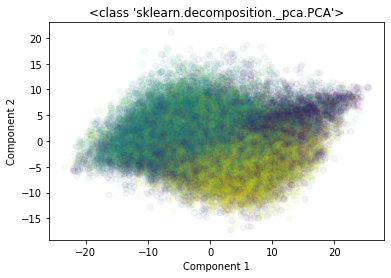

In [30]:
fig, ax = plt.subplots(1, 1)
_ = ax.scatter(engineered_train_features[:,0], engineered_train_features[:,1], c=train_target, alpha=0.05)
_ = ax.set_xlabel("Component 1")
_ = ax.set_ylabel("Component 2")
_ = ax.set_title(type(decomposer))

### Exercise

Take a close look at the doc string for the `decomposition.PCA` algorithm. What happens if you set `n_components` to a number between 0 and 1 (i.e., `n_components=0.95`)? Why might you want to do this? What does setting `whiten=True` do to the output of the algorithm? Re-run the PCA algorithm above setting `whiten=True` to confirm your answer. Why might you want to set `whiten=True`? 

### Exercise

Explore the documentation of the `decomposition.KernelPCA` algorithm. How can you recover PCA using this algorithm? Confirm your hypothesis. Explore different kernels.

In [32]:
decomposition.FastICA?

Init signature:
decomposition.FastICA(
    n_components=None,
    *,
    algorithm='parallel',
    whiten=True,
    fun='logcosh',
    fun_args=None,
    max_iter=200,
    tol=0.0001,
    w_init=None,
    random_state=None,
)
Docstring:     
FastICA: a fast algorithm for Independent Component Analysis.

The implementation is based on [1]_.

Read more in the :ref:`User Guide <ICA>`.

Parameters
----------
n_components : int, default=None
    Number of components to use. If None is passed, all are used.

algorithm : {'parallel', 'deflation'}, default='parallel'
    Apply parallel or deflational algorithm for FastICA.

whiten : bool, default=True
    If whiten is false, the data is already considered to be
    whitened, and no whitening is performed.

fun : {'logcosh', 'exp', 'cube'} or callable, default='logcosh'
    The functional form of the G function used in the
    approximation to neg-entropy. Could be either 'logcosh', 'exp',
    or 'cube'.
    You can also provide your own functi

In [31]:
# define some hyperparameters
KERNEL = "linear"

decomposer = decomposition.KernelPCA(
    eigen_solver="randomized",
    kernel=KERNEL,
    n_components=N_COMPONENTS,
    n_jobs=TRAIN_N_JOBS,
    random_state=_random_state,
)
engineered_train_features = decomposer.fit_transform(preprocessed_train_features)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 1)
_ = ax.scatter(engineered_train_features[:,0], engineered_train_features[:,1], c=train_target, alpha=0.05)
_ = ax.set_xlabel("Component 1")
_ = ax.set_ylabel("Component 2")
_ = ax.set_title(type(decomposer))

## Transformation pipelines

In [69]:
preparation_pipeline = pipeline.make_pipeline(
    preprocessing.MinMaxScaler(feature_range=(DATA_MIN, DATA_MAX)),
    decomposition.PCA(n_components=N_COMPONENTS, random_state=_random_state, whiten=WHITEN),
    verbose=True,
)

prepared_train_features = preparation_pipeline.fit_transform(train_features)

[Pipeline] ............... (step 1 of 2) Processing pca, total=  34.9s
[Pipeline] ...... (step 2 of 2) Processing minmaxscaler, total=   0.1s


In [73]:
prepared_train_features.min(axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [74]:
prepared_train_features.mean(axis=0)

array([0.47846739, 0.44967182, 0.48269768, 0.47451942, 0.46019379,
       0.49521579, 0.49808116, 0.48429881, 0.44402805, 0.42460106,
       0.45540122, 0.37477341, 0.49561654, 0.48985072, 0.49399286,
       0.47797721, 0.36608505, 0.49080662, 0.47419291, 0.43556766,
       0.47284536, 0.48251413, 0.48757576, 0.48784904, 0.46908483,
       0.45718786, 0.48157383, 0.49302339, 0.43686232, 0.45743304,
       0.49273923, 0.4886735 , 0.47356631, 0.47184561, 0.46415774,
       0.42611529, 0.49457412, 0.48442359, 0.49545126, 0.46951548,
       0.49866142, 0.48545648, 0.48259352, 0.4606646 , 0.47746631,
       0.44246341, 0.43097092, 0.48934292, 0.46427017, 0.46813988,
       0.49157192, 0.45609154, 0.47298608, 0.43529997, 0.47717167,
       0.47595756, 0.49466898, 0.45865973, 0.41220985, 0.48932225,
       0.48059383, 0.47275229, 0.47617366, 0.48520128, 0.49286   ,
       0.49016688, 0.40854129, 0.47241295, 0.48826193, 0.47804404,
       0.47136574, 0.42857186, 0.46184163, 0.48891764, 0.47064

In [75]:
prepared_train_features.max(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Select and train a model

In [215]:
linear_model.SGDClassifier?

Init signature:
linear_model.SGDClassifier(
    loss='hinge',
    *,
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    n_jobs=None,
    random_state=None,
    learning_rate='optimal',
    eta0=0.0,
    power_t=0.5,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    warm_start=False,
    average=False,
)
Docstring:     
Linear classifiers (SVM, logistic regression, etc.) with SGD training.

This estimator implements regularized linear models with stochastic
gradient descent (SGD) learning: the gradient of the loss is estimated
each sample at a time and the model is updated along the way with a
decreasing strength schedule (aka learning rate). SGD allows minibatch
(online/out-of-core) learning via the `partial_fit` method.
For best results using the default learning rate schedule, the data should
have zero mean and uni

In [221]:
TRAIN_N_JOBS = -1
VERBOSITY = 1

In [216]:
# select and estimator and fit
estimator = linear_model.SGDClassifier(loss="log",
                                       random_state=_random_state,
                                       n_jobs=TRAIN_N_JOBS,
                                       verbose=VERBOSITY)
_ = estimator.fit(prepared_train_features, train_target)

# make predictions
predictions = estimator.predict(prepared_train_features)

# report the accuracy on the training data
metrics.accuracy_score(
    train_target,
    predictions,
)

0.3837407407407407

In [ ]:
tree.DecisionTreeClassifier?

In [217]:
# select and estimator and fit
estimator = tree.DecisionTreeClassifier(random_state=_random_state,)
_ = estimator.fit(prepared_train_features, train_target)

# make predictions
predictions = estimator.predict(prepared_train_features)

# report the accuracy on the training data
metrics.accuracy_score(
    train_target,
    predictions,
)

1.0

In [ ]:
ensemble.RandomForestClassifier?

In [218]:
# select and estimator and fit
estimator = ensemble.RandomForestClassifier(random_state=_random_state,
                                            n_jobs=TRAIN_N_JOBS,
                                            verbose=VERBOSITY)
_ = estimator.fit(prepared_train_features, train_target)

# make predictions
predictions = estimator.predict(prepared_train_features)

# report the accuracy on the training data
metrics.accuracy_score(
    train_target,
    predictions,
)

1.0

### Exercise

Explore the various options for `linear_model.SGDClassifier`. Can you find something that does better than Logistic Regression?

## Better evaluation using cross-validation

In [219]:
CV_FOLDS = 8
CV_N_JOBS = CV_FOLDS

In [220]:
estimator = linear_model.SGDClassifier(loss="log",
                                       random_state=_random_state,
                                       n_jobs=TRAIN_N_JOBS,
                                       verbose=VERBOSITY)

estimator_scores = model_selection.cross_val_score(estimator,
                                                   X=prepared_train_features,
                                                   y=train_target,
                                                   cv=CV_FOLDS,
                                                   scoring="accuracy",
                                                   n_jobs=CV_N_JOBS)

In [222]:
estimator_scores.mean()

0.3579074074074074

In [223]:
estimator = tree.DecisionTreeClassifier(random_state=_random_state)

estimator_scores = model_selection.cross_val_score(estimator,
                                                   X=prepared_train_features,
                                                   y=train_target,
                                                   cv=CV_FOLDS,
                                                   scoring="accuracy",
                                                   n_jobs=CV_N_JOBS)

In [224]:
estimator_scores.mean()

0.2570555555555556

In [225]:
estimator = ensemble.RandomForestClassifier(random_state=_random_state,
                                            n_jobs=TRAIN_N_JOBS,
                                            verbose=VERBOSITY)

estimator_scores = model_selection.cross_val_score(estimator,
                                                   X=prepared_train_features,
                                                   y=train_target,
                                                   cv=CV_FOLDS,
                                                   scoring="accuracy",
                                                   n_jobs=CV_N_JOBS)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  34 tasks     

In [226]:
estimator_scores.mean()

0.433962962962963

### Exercise:

Explore other classification algorithms available in Scikit-Learn. See if you can find a model that outperforms `ensemble.RandomForestClassifier`.

In [227]:
estimator = ensemble.HistGradientBoostingClassifier(random_state=_random_state,
                                                    verbose=VERBOSITY)
_ = estimator.fit(prepared_train_features, train_target)

# make predictions
predictions = estimator.predict(prepared_train_features)

# report the accuracy on the training data
metrics.accuracy_score(
    train_target,
    predictions,
)

Binning 0.084 GB of training data: 1.433 s
Binning 0.009 GB of validation data: 0.032 s
Fitting gradient boosted rounds:
[1/100] 10 trees, 310 leaves (31 on avg), max depth = 15, train loss: 2.17302, val loss: 2.19649, in 0.403s
[2/100] 10 trees, 310 leaves (31 on avg), max depth = 13, train loss: 2.08118, val loss: 2.12030, in 0.378s
[3/100] 10 trees, 310 leaves (31 on avg), max depth = 14, train loss: 2.00849, val loss: 2.06144, in 0.354s
[4/100] 10 trees, 310 leaves (31 on avg), max depth = 12, train loss: 1.94850, val loss: 2.01273, in 0.366s
[5/100] 10 trees, 310 leaves (31 on avg), max depth = 15, train loss: 1.89547, val loss: 1.97182, in 0.351s
[6/100] 10 trees, 310 leaves (31 on avg), max depth = 16, train loss: 1.84877, val loss: 1.93640, in 0.374s
[7/100] 10 trees, 310 leaves (31 on avg), max depth = 14, train loss: 1.80740, val loss: 1.90543, in 0.343s
[8/100] 10 trees, 310 leaves (31 on avg), max depth = 14, train loss: 1.77033, val loss: 1.87804, in 0.344s
[9/100] 10 tree

0.8182592592592592

In [229]:
estimator = ensemble.HistGradientBoostingClassifier(random_state=_random_state,
                                                    verbose=0)
estimator_scores = model_selection.cross_val_score(estimator,
                                                   X=prepared_train_features,
                                                   y=train_target,
                                                   cv=CV_FOLDS,
                                                   scoring="accuracy",
                                                   n_jobs=CV_N_JOBS)

In [230]:
estimator_scores.mean()

0.5065185185185186

### Exercise:

Several of the models that we tried were able to memorize the training data, but performed poorly when using CV: they overfit and need to be regularized. Pick a model. Explore the documentation for your model. Hand-tune some of the hyper-parameters of the model in order to regularize the model and reduce overfitting.

# Fine-tune your models

Two key parameters are `n_estimators` and `max_features`

## Grid Search

In [165]:
parameter_grid = [
#    {"n_estimators": [12, 25, 50, 100], "max_features": [2, 4, 8, "sqrt"]}, # 3 * 3 = 9 parameter combinations to try
    {"max_depth": [None], "min_samples_split": [128, 256, 512, 1024]}
]

_random_state = np.random.RandomState(42)
_estimator = ensemble.RandomForestClassifier(
    random_state=_random_state
)
estimator = model_selection.GridSearchCV(
    _estimator,
    parameter_grid,
    cv=CV_FOLDS,
    scoring="accuracy",
    return_train_score=True,
    n_jobs=CV_N_JOBS,
    verbose=10)

In [166]:
_ = estimator.fit(prepared_train_features, train_target)

Fitting 8 folds for each of 4 candidates, totalling 32 fits
[CV 8/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 4/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 1/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 5/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 2/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 6/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 7/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 3/8; 1/4] START max_depth=None, min_samples_split=128.......................
[CV 8/8; 1/4] END max_depth=None, min_samples_split=128;, score=(train=0.664, test=0.451) total time= 1.4min
[CV 1/8; 2/4] START max_depth=None, min_samples_split=256.......................
[CV 2/8; 1/4] END max_depth=None, min_samples_split=128;, score=(train=0.667, test=0.445) total time= 

In [167]:
estimator.best_score_

0.4459444444444445

In [168]:
estimator.best_params_

{'max_depth': None, 'min_samples_split': 128}

In [163]:
estimator.best_estimator_

RandomForestClassifier(min_samples_split=32,
                       random_state=RandomState(MT19937) at 0x12FD74E40)

In [164]:
max([e.get_depth() for e in estimator.best_estimator_.estimators_])

56

In [124]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(estimator, f"../results/models/grid-search-cv-random-forest-classifier-{timestamp}.pkl")

For reference here is how you would reload the trained model from the file.

In [125]:
reloaded_estimator = joblib.load(f"../results/models/grid-search-cv-random-forest-classifier-{timestamp}.pkl")

In [126]:
reloaded_estimator.best_params_

{'max_features': 'auto', 'n_estimators': 100}

## Randomized Search

In [129]:
from scipy import stats


_param_distributions = {
    "n_estimators": stats.geom(p=0.01),
    "min_samples_split": stats.beta(a=1, b=99),
    "min_samples_leaf": stats.beta(a=1, b=999),
}

_random_state = np.random.RandomState(42)
_estimator = ensemble.RandomForestClassifier(random_state=_random_state)

estimator = model_selection.RandomizedSearchCV(
    _estimator,
    param_distributions=_param_distributions,
    scoring="accuracy",
    random_state=_random_state,
    n_iter=10,
    cv=CV_FOLDS,
    n_jobs=CV_N_JOBS,
    verbose=10
)

In [130]:
_ = estimator.fit(prepared_train_features, train_target)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 1/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 5/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 3/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 2/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 4/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 7/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 6/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_estimators=92
[CV 8/8; 1/10] START min_samples_leaf=0.00048658611411275555, min_samples_split=0.0005870677503007284, n_e

In [131]:
estimator.best_score_

0.4470185185185185

In [132]:
estimator.best_params_

{'min_samples_leaf': 0.00048658611411275555,
 'min_samples_split': 0.0005870677503007284,
 'n_estimators': 92}

In [133]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
_ = joblib.dump(estimator, f"../results/models/randomized-search-cv-random-forest-classifier-{timestamp}.pkl")

### Exercise:

Fine-tune one of your models using Grid Search; fine-tune another model using Randomized Search.

# Analyze the best models and their errors

In [134]:
# make predictions
predictions = (estimator.best_estimator
                        .predict(prepared_train_features))

# generate a classification report
classification_report = metrics.classification_report(
    train_target,
    predictions,
)
print(classification_report)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 3/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143
[CV 2/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143
[CV 4/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143
[CV 7/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143[CV 1/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143

[CV 6/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143
[CV 8/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators=143
[CV 5/8; 1/10] START min_samples_leaf=0.0012740020283231776, min_samples_split=0.001251580605759922, n_estimators

KeyboardInterrupt: 

# Evaluate your models on the test dataset